# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
from bs import simulate_BS


start_date = '1690-01-01'
end_date = '2023-01-01'

t = pd.date_range(start=start_date, end=end_date,freq = 'ME')
n_timestep = len(t)
df = pd.DataFrame({'Date': t, 'spx': t})
df.set_index('Date', inplace=True)
dt = 1/12
mu = 0.1
sigma = 0.2
BS_paths = simulate_BS(1, dt, n_timestep-1, mu, sigma)
path = BS_paths[0,:,0].numpy().astype(np.float64)
df['spx'] = path
df.to_csv('data/bs.csv')
# df.to_csv('data/spx.csv')

# df = pd.read_csv('data/spx.csv', index_col=0, parse_dates=True)
# df.info()
df = pd.read_csv('data/bs.csv', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3996 entries, 1690-01-31 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     3996 non-null   float64
dtypes: float64(1)
memory usage: 62.4 KB


In [4]:
# samples
batch_size = 256 # number of samples in each batch
sample_len = 61 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = False # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42


# BS
batch_size = 64 # number of samples in each batch
sample_len = 61 # length of each sample
stride = 60


In [5]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 5 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = False # feed in history for LSTM generators

In [6]:
noise_dim = 1 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 5

### Training Related

In [7]:
epochs = 1000 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.2 # starting kernel_sigma
num_losses = 20

### Save to tensorboard log

In [8]:
# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)

### Data, kernel, generator

In [9]:
dataloader = get_dataloader(**{**data_params, **model_params, 'bs':True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5664.477733792164
            Iterations: 10
            Function evaluations: 83
            Gradient evaluations: 10
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5664.48
Distribution:                  Normal   AIC:                           11341.0
Method:            Maximum Likelihood   BIC:                           11378.7
                                        No. Observations:                 3995
Date:                Fri, Sep 06 2024   Df Residuals:                     3995
Time:                        09:07:36   Df Model:                            0
                               Volatility Model                              
  

GenLSTM(
  (rnn): LSTM(3, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

# Train MMD-GAN

In [10]:
# train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

In [11]:
base_path = 'runs/Sep05_09-51-14_ada-29_rq_5/'
generator.load_state_dict(torch.load(base_path+'generator.pt'))

<All keys matched successfully>

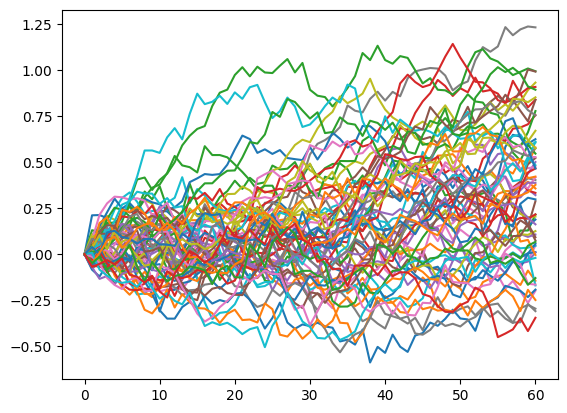

66
torch.Size([64, 61, 2])
torch.Size([64, 60, 1])


In [12]:
# Visualize data
for item in dataloader:
    plt.plot(item[0][:,:,1].T)
plt.show()
print(len(dataloader.dataset))
print(item[0].shape)
print(item[1].shape)

In [13]:
path = item[0]
n_noise = 50000

t_single = path[:1,:,:1]
t = torch.tile(t_single, [n_noise,1,1])

self = dataloader.dataset

ma_model = arch.arch_model(self.df['spx'], mean=MEAN_MODEL, p=self.p, q=Q_CONST, rescale=False)
ma_model.distribution = Normal(seed=self.rs)
forecasts = ma_model.forecast(params=self.res.params, horizon=self.sample_len-1, method='simulation', simulations=n_noise)
noise = forecasts.simulations.residuals[0].T
noise = torch.tensor(noise, dtype=path.dtype, requires_grad=False)
noise = torch.swapaxes(noise, 0, 1).unsqueeze(2)

print(noise.shape, t.shape)
generator.to('cpu')
with torch.no_grad():
    output = generator(noise, t)
    output = torch.cat([t, output], axis=-1) # concatenate time and generated path along time series value dimension

torch.Size([50000, 60, 1]) torch.Size([50000, 61, 1])


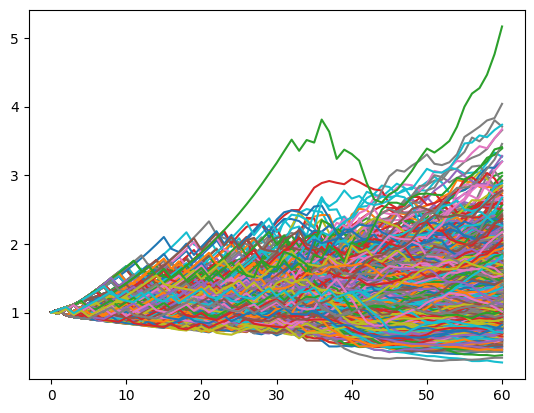

In [14]:
fake_paths = output[:,:,1].exp()

plt.plot(fake_paths[:1000].T);
torch.save(fake_paths,base_path + 'fake_path.pth')